Our objective is to build a neural network for the classification of the MNIST dataset. This neural network will comprise of: an output layer with 10 nodes, a hidden layer of 128 nodes, and an input layer with 784 nodes corresponding to the image pixels. The specific structure of the neural network is outlined below, where $X$ represents the input, $A^{[0]}$ denotes the first layer, $Z^{[1]}$ signifies the unactivated layer 1, $A^{[1]}$ stands for the activated layer 1, and so forth. The weights and biases are represented by $W$ and $b$ respectively:

<div align="center">

$A^{[0]}=X$

$Z^{[1]}=W^{[1]}A^{[0]}+b^{[1]}$

$A^{[1]}=\text{ReLU}(Z^{[1]})$

$Z^{[2]}=W^{[2]}A^{[1]}+b^{[2]}$

$A^{[2]}=\text{softmax}(Z^{[2]})$

$Loss=\text{cross-entropy-loss}(A^{[2]})$
</div>

You have the flexibility to create any function within or outside the class, allowing you to modify parameters as needed

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
mnist = tf.keras.datasets.mnist
import matplotlib.pyplot as plt

Now you will implement the activation function(ReLU) and softmax function

In [3]:
def ReLU(Z):
    return np.maximum(Z,0)
    pass

def softmax(Z):
    expZ = np.exp(Z)
    return expZ/np.sum(expZ, axis=0)
    pass

def derivative_relu(x):
    return np.array(x > 0, dtype=np.float32)


Now comes the important part.

In this, you will implement the NN class, which will be the model you will be using to train data on and later use it to predict.

You have been given the init function, you have to implement all the other functions yourself, in any way you like ... you may even skip some of them if you don't need them in the final implementation of the class.

The description of each function has been given in the comments

In [4]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # initialized basic stats of NN
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.learning_rate=learning_rate

        #initialized weights and biases
        self.W1=np.random.randn(hidden_size, input_size)*0.01
        self.b1= np.zeros((hidden_size, 1))
        self.W2=np.random.randn(output_size, hidden_size)*0.01
        self.b2=np.zeros((output_size, 1))

        #initialized activations and gradients
        self.AO=None
        self.Z1=None
        self.A1=None
        self.Z2=None
        self.A2=None
        self.dW2=None
        self.db2=None
        self.dW1=None
        self.db1=None

    # do the forward pass and evaluate the values of A0, Z1, A1, Z2, A2
    def forward_propagation(self, X):
        self.A0 = X
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = ReLU(self.Z1)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = softmax(self.Z2)

        forward_cache = {
            "z1": self.Z1,
            "a1": self.A1,
            "z2": self.Z2,
            "a2": self.A2
        }

        return forward_cache
        
        pass
    
    # convert the input y, into a one hot encoded array.
    '''
    one hot encoding is:
    you have an array with values [2, 5, 6] and you know the max value can be 8, then one hot encoded array will be:
    [[0,0,1,0,0,0,0,0,0], [0,0,0,0,0,1,0,0,0], [0,0,0,0,0,0,1,0,0]]
    Note that the index 2, 5, 6 have values 1 and all others have values 0
    '''
    def one_hot(self, y):
        one_hot_y = np.zeros((y.max() + 1, y.size))
        one_hot_y[y, np.arange(y.size)] = 1
        return one_hot_y
        pass

    # calculate the derivative of the loss function with respect to W2, b2, W1, b1 in dW2, db2, dW1, db1 respectively
    def backward_propagation(self, X, y, forward_cache):
        a1 = forward_cache['a1']
        a2 = forward_cache['a2']

        m = X.shape[1]

        dz2 = (a2 - y)
        self.dW2 = (1/m)*np.dot(dz2, a1.T)
        self.db2 = (1/m)*np.sum(dz2, axis=1, keepdims=True)

        dz1 = np.dot(self.W2.T, dz2) * derivative_relu(self.Z1)
        self.dW1 = (1/m)*np.dot(dz1, X.T)
        self.db1 = (1/m)*np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            "dw1": self.dW1,
            "db1": self.db1,
            "dw2": self.dW2,
            "db2": self.db2
        }

        return gradients
        pass
    
    # update the parameters W1, W2, b1, b2
    def update_params(self, gradients):
        dw1 = gradients['dw1']
        db1 = gradients['db1']
        dw2 = gradients['dw2']
        db2 = gradients['db2']

        self.W1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2
        pass
    
    # get the predictions for the dataset
    def get_predictions(self, X):
        forward_cache = self.forward_propagation(X)
        predictions = np.argmax(forward_cache['a2'], axis=0)
        return predictions
        pass

    # get the accuracy of the model on the dataset
    def get_accuracy(self, X, y):
        predictions = self.get_predictions(X)
        return np.mean(predictions == y)
        pass

    # run gradient descent on the model to get the values of the parameters
    def gradient_descent(self, X, y, iters=1000):
        y_one_hot = self.one_hot(y)

        for i in range(iters):
            forward_cache = self.forward_propagation(X)
            gradients = self.backward_propagation(X, y_one_hot, forward_cache)
            self.update_params(gradients)
            
            if i % 100 == 0:
                cost = self.cross_entropy_loss(y_one_hot, forward_cache['a2'])
                print(f"Iteration {i}, Cost: {cost}")
        pass
    
    # evaluate loss using cross-entropy-loss formula.
    def cross_entropy_loss(self, X, y):
        m = y.shape[1]
        loss = -(1/m)*np.sum(y * np.log(self.A2))
        return loss
        pass

    # Let me help a bit hehe :)
    def show_predictions(self, X, y, num_samples=10):
        random_indices = np.random.randint(0, X.shape[1], size=num_samples)

        for index in random_indices:
            sample_image = X[:, index].reshape((28, 28))
            plt.imshow(sample_image, cmap='gray')
            plt.title(f"Actual: {y[index]}, Predicted: {self.get_predictions(X[:, index:index+1])[0]}")
            plt.show()

Now we are splitting the dataset into training and testing data

In [5]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

miu = np.mean(X_train, axis=(0, 1), keepdims=True)
stds = np.std(X_train, axis=(0, 1), keepdims=True)

mius = np.mean(X_test, axis=(0, 1), keepdims=True)
stdse = np.std(X_test, axis=(0, 1), keepdims=True)

X_normal_train = (X_train - miu) / (stds + 1e-7)
X_normal_test = (X_test - mius) / (stdse + 1e-7)

X_normal_train = X_normal_train.reshape((60000, -1)).T
X_normal_test = X_normal_test.reshape((10000, -1)).T

Now you will train the model on X_normal_train and Y_train dataset

Then print the accuracy of model on X_normal_test and Y_test dataset

Iteration 0, Cost: 2.302389286005952
Iteration 100, Cost: 2.277789073352004
Iteration 200, Cost: 2.135053464858892
Iteration 300, Cost: 1.6648103907091354
Iteration 400, Cost: 1.2333004580051001
Iteration 500, Cost: 0.9839980089970487
Iteration 600, Cost: 0.8314997727815052
Iteration 700, Cost: 0.7289587266280392
Iteration 800, Cost: 0.6551654146057564
Iteration 900, Cost: 0.599607061332125
Train Accuracy: 89.86%
Test Accuracy: 90.17%


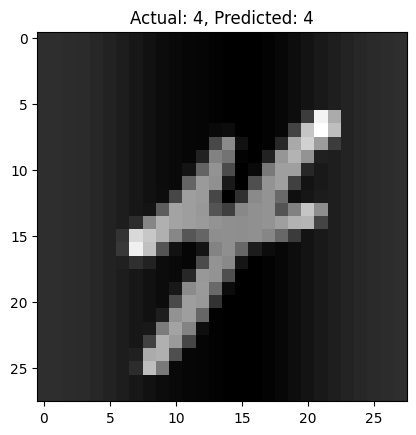

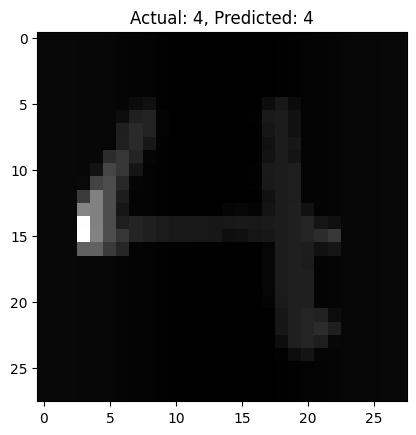

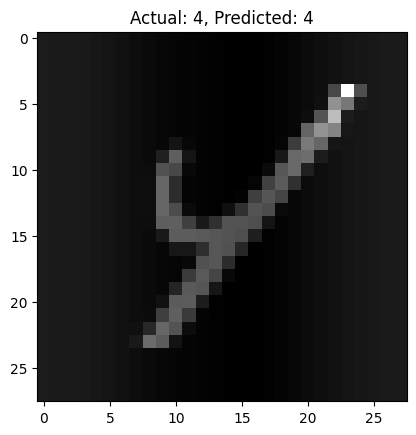

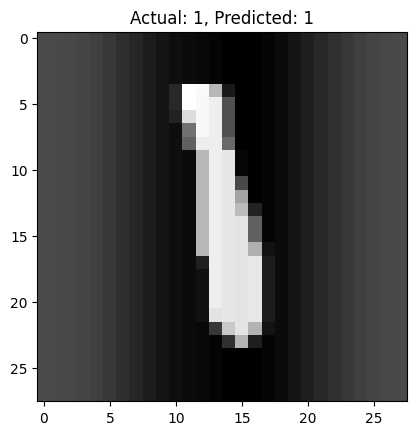

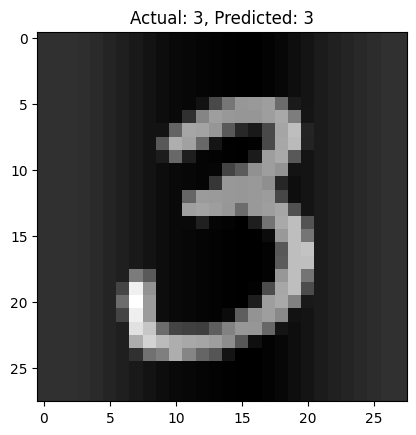

In [6]:
# All the best :)
nn = NN(input_size=784, hidden_size=128, output_size=10, learning_rate=0.01)
nn.gradient_descent(X_normal_train, Y_train, iters=1000)

train_accuracy = nn.get_accuracy(X_normal_train, Y_train)
test_accuracy = nn.get_accuracy(X_normal_test, Y_test)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

nn.show_predictions(X_normal_test, Y_test, num_samples=5)
pass